# Linear Regression

本次作業的資料是從中央氣象局網站下載的真實觀測資料，大家必須利用 linear regression 或其他方法預測 PM2.5 的數值。

觀測記錄被分成 train set 跟 test set，前者是每個月的前 20 天所有資料；後者則是從剩下的資料中隨機取樣出來的。

train.csv: 每個月前 20 天的完整資料。

test.csv: 從剩下的 10 天資料中取出 240 筆資料。每一筆資料都有連續 9 小時的觀測數據，兒童學必須以此預測第十小時的 PM2.5。

## Load 'train.csv'

train.csv文件中包含12个月中，每个月取前20天，每天24小时（每个小时18个feature）的数据。

In [1]:
%matplotlib inline

In [2]:
import sys
import pandas as pd
import numpy as np
import math
import csv
from matplotlib import pyplot as plt

In [3]:
# from google.colab import drive
# !gdown --id '1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm' --output data.zip
# !unzip data.zip
data = pd.read_csv('./train.csv', header = None, encoding = 'big5')
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
# data = pd.read_csv('./train.csv', encoding = 'big5')

## Preprocessing

取需要的数值部分，将“RAINFALL”栏中位置全部补0。另外，若想重跑下面的代码，则最好将上面的一起重跑一遍，以免得到意外结果。

In [4]:
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

## Extract Featrues(1)

将原始4320x18的数据依照每个月分重組成12个18(features)x480(hours)的数据。

In [5]:
month_data = {}
for month in range(12):
    sample = np.empty([18,480])
    for day in range(20):
        sample[:, day*24 : (day+1)*24] = raw_data[18*(20*month+day) : 18*(20*month+day+1), :]
    month_data[month] = sample

## Extract Featrues(2)

每个月会有480hrs，每9小時形成一个data，每个月会有471个data，故总数据数为471x12块，而每块data有9x18的features(一个小时18个features x
9小时)。

對应的target则有471x12个(第10个小时的PM2.5)

In [6]:
x = np.empty([12*471, 18*9], dtype = float)
y = np.empty([12*471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month*471 + day*24 + hour, :] = month_data[month][:,day*24 + hour : day*24 + hour + 9].reshape(1, -1)
            y[month*471 + day*24 + hour, 0] = month_data[month][9, day*24 + hour + 9]
print(x)
print(y)

[[0.  1.  2.  ... 2.5 2.  0.6]
 [1.  2.  3.  ... 2.  0.6 0.8]
 [2.  3.  4.  ... 0.6 0.8 1.6]
 ...
 [0.8 1.8 2.6 ... 1.5 1.  1.7]
 [1.8 2.6 1.4 ... 1.  1.7 1.5]
 [2.6 1.4 1.7 ... 1.7 1.5 2. ]]
[[38.]
 [56.]
 [64.]
 ...
 [50.]
 [32.]
 [22.]]


## Normalize(1)

In [7]:
mean_x = np.mean(x, axis = 0) # 18*9
std_x = np.std(x, axis = 0) # 18*9
for i in range(len(x)): # 12*471
    for j in range(len(x[0])): # 18*9
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j])/std_x[j]
print(x)

[[-1.32940065 -0.57052916  0.18849156 ...  0.18190364 -0.28611588
  -1.59862324]
 [-0.57043373  0.18838607  0.9474531  ... -0.28631722 -1.59712273
  -1.41122474]
 [ 0.18853318  0.9473013   1.70641464 ... -1.59733562 -1.40983604
  -0.66163075]
 ...
 [-0.72222712  0.03660302  0.64386849 ... -0.75453808 -1.22254934
  -0.5679315 ]
 [ 0.0367398   0.64373521 -0.26688536 ... -1.22275893 -0.56704592
  -0.75533   ]
 [ 0.64391333 -0.26696307 -0.0391969  ... -0.56724973 -0.75433261
  -0.28683376]]


## Split Training Data Into "train_set" and "validation_set"

这部分是针对作业中report的第二题、第三题做的简单示范，以生成比较中用來训练的train_set和不会被放入训练、只是用來验证的validation_set。

In [8]:
x_train_set = x[: math.floor(len(x)*0.8), :]
y_train_set = y[: math.floor(len(y)*0.8), :]

x_validation = x[math.floor(len(x)*0.8): , :]
y_validation = y[math.floor(len(y)*0.8): , :]

print(x_train_set)
print(y_train_set)
print(x_validation)
print(y_validation)
print(len(x_train_set))
print(len(y_train_set))
print(len(x_validation))
print(len(y_validation))

[[-1.32940065 -0.57052916  0.18849156 ...  0.18190364 -0.28611588
  -1.59862324]
 [-0.57043373  0.18838607  0.9474531  ... -0.28631722 -1.59712273
  -1.41122474]
 [ 0.18853318  0.9473013   1.70641464 ... -1.59733562 -1.40983604
  -0.66163075]
 ...
 [ 1.32698356  0.87140977  1.9341031  ...  0.93105701 -1.128906
  -0.9427285 ]
 [ 0.87160341  1.93389109  2.08589541 ... -1.12911476 -0.9416193
  -1.03642775]
 [ 1.93415709  2.08567414  2.61716849 ... -0.94182642 -1.03526265
  -0.84902925]]
[[38.]
 [56.]
 [64.]
 ...
 [22.]
 [22.]
 [24.]]
[[ 2.08595047  2.61691479  1.40283003 ... -1.03547059 -0.84797596
  -1.03642775]
 [ 2.61722732  1.40265043  1.09924541 ... -0.84818225 -1.03526265
   1.39975272]
 [ 1.40288025  1.09908434  0.71976464 ... -1.03547059  1.39946436
  -0.84902925]
 ...
 [-0.72222712  0.03660302  0.64386849 ... -0.75453808 -1.22254934
  -0.5679315 ]
 [ 0.0367398   0.64373521 -0.26688536 ... -1.22275893 -0.56704592
  -0.75533   ]
 [ 0.64391333 -0.26696307 -0.0391969  ... -0.56724973

## Training

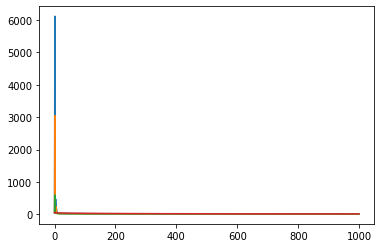

In [9]:
dim = 18*9+1
w = np.zeros([dim, 1])
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001

for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x,w) - y, 2))/471/12) #RMSE
    if t%100 == 0 :
        print(str(t) + ":" + str(loss))
    gradient = 2*np.dot(x.transpose(), np.dot(x,w) - y) #dim*1
    adagrad += gradient**2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight.npy', w)
print(w)

## Testing

In [9]:
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
print(test_x)

[[ 1.         14.6089046  14.60777537 ... -1.22275893 -1.59712273
  -0.47423225]
 [ 1.          9.29613618  8.53645356 ... -0.37996139 -0.66068927
  -1.03642775]
 [ 1.         22.95754068 22.19692764 ... -1.87826813 -1.59712273
  -1.13012699]
 ...
 [ 1.         17.64477226 18.4023515  ... -0.28631722 -0.75433261
   0.65015873]
 [ 1.          7.01923543  7.01862311 ... -1.59733562 -1.69076608
  -1.69232249]
 [ 1.          9.29613618  9.29536879 ...  2.42936375  2.71047121
   1.21235422]]


/home/duzexu/anaconda3/envs/ml20/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/duzexu/anaconda3/envs/ml20/lib/python3.6/site-packages/pandas/core/frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


## Prediction

In [10]:
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
print(ans_y)

[[ 220.85239735]
 [ 318.78482367]
 [ 633.59196739]
 [ 274.72185656]
 [ 589.49811955]
 [ 312.91782197]
 [ 122.9915125 ]
 [ -55.15581024]
 [ 744.24903158]
 [ 794.95951473]
 [-277.34019766]
 [ 623.23898475]
 [1581.78739787]
 [ 601.03975301]
 [ 574.31329378]
 [ 285.35413388]
 [1045.83996196]
 [1220.10850237]
 [ 798.6799921 ]
 [ 399.01634709]
 [ 530.26085263]
 [-111.30767333]
 [ 540.48442601]
 [ 756.86800736]
 [ 333.41100629]
 [ 727.41145817]
 [ 649.33812135]
 [ 666.26170942]
 [ 192.85749955]
 [1190.41649923]
 [ 587.80261873]
 [1296.48723489]
 [ 367.61147203]
 [ 326.88801256]
 [1360.03206926]
 [1128.51984269]
 [ 408.02945778]
 [ 149.72398763]
 [1143.60139983]
 [ 769.53515161]
 [ 700.34526903]
 [-104.7258681 ]
 [1421.72994698]
 [  40.95138549]
 [-303.6259606 ]
 [1204.02086934]
 [ 387.92008601]
 [ 390.98503865]
 [ 632.32832565]
 [ 281.53761576]
 [ 478.16788541]
 [ 621.9533526 ]
 [ 654.9599191 ]
 [  55.89683665]
 [ 144.45240628]
 [ 998.24890283]
 [ 759.49416848]
 [ 104.80638233]
 [ 138.9212693

## Save Prediction to CSV File

In [11]:
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 220.85239735293067]
['id_1', 318.7848236743183]
['id_2', 633.5919673949488]
['id_3', 274.7218565586508]
['id_4', 589.498119551853]
['id_5', 312.9178219678073]
['id_6', 122.99151250006298]
['id_7', -55.15581024478024]
['id_8', 744.2490315802564]
['id_9', 794.9595147310847]
['id_10', -277.34019766419533]
['id_11', 623.23898474736]
['id_12', 1581.7873978743232]
['id_13', 601.0397530116563]
['id_14', 574.313293783058]
['id_15', 285.35413387806574]
['id_16', 1045.8399619620182]
['id_17', 1220.1085023693954]
['id_18', 798.6799921041178]
['id_19', 399.01634709313817]
['id_20', 530.2608526297249]
['id_21', -111.30767333420204]
['id_22', 540.4844260057546]
['id_23', 756.8680073561774]
['id_24', 333.41100629119285]
['id_25', 727.4114581661638]
['id_26', 649.3381213452712]
['id_27', 666.2617094204925]
['id_28', 192.8574995521626]
['id_29', 1190.4164992324966]
['id_30', 587.8026187295274]
['id_31', 1296.4872348890758]
['id_32', 367.6114720259019]
['id_33', 326.888012560237

相關 reference 可以參考:

Adagrad : https://youtu.be/yKKNr-QKz2Q?list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&t=705

RMSprop : https://www.youtube.com/watch?v=5Yt-obwvMHI

Adam https://www.youtube.com/watch?v=JXQT_vxqwIs

以上 print 的部分主要是為了看一下資料和結果的呈現，拿掉也無妨。另外，在自己的 linux 系統，可以將檔案寫死的的部分換成 sys.argv 的使用 (可在 terminal 自行輸入檔案和檔案位置)。

最後，可以藉由調整 learning rate、iter_time (iteration 次數)、取用 features 的多寡(取幾個小時，取哪些特徵欄位)，甚至是不同的 model 來超越 baseline。

Report 的問題模板請參照 : https://docs.google.com/document/d/1s84RXs2AEgZr54WCK9IgZrfTF-6B1td-AlKR9oqYa4g/edit

## 作业

備註 : 
      
      a. 1~3題的回答中，NR 請皆設為 0，其他的數值不要做任何更動。
      b. 可以使用所有 advanced 的 gradient descent 技術（如 Adam、Adagrad）。
      c. 1~3題請用linear regression的方法進行討論作答。
    
1. (2%) 使用四種不同的 learning rate 進行 training (其他參數需一致)，作圖並討論其收斂過程（橫軸為 iteration 次數，縱軸為 loss 的大小，四種 learning rate 的收斂線請以不同顏色呈現在一張圖裡做比較）。

2. (1%) 比較取前 5 hrs 和前 9 hrs 的資料（5*18 + 1 v.s 9*18 + 1）在 validation set 上預測的結果，並說明造成的可能原因（1. 因為 testing set 預測結果要上傳 Kaggle 後才能得知，所以在報告中並不要求同學們呈現 testing set 的結果，至於什麼是 validation set 請參考：https://youtu.be/D_S6y0Jm6dQ?t=1949 2. 9hr:取前9小時預測第10小時的PM2.5；5hr:在前面的那些features中，以5~9hr預測第10小時的PM2.5。這樣兩者在相同的validation set比例下，會有一樣筆數的資料）。

3. (1%) 比較只取前 9 hrs 的 PM2.5 和取所有前 9 hrs 的 features（9*1 + 1 vs. 9*18 + 1）在 validation set上預測的結果，並說明造成的可能原因。

4. (2%) 請說明你超越 baseline 的 model(最後選擇在Kaggle上提交的) 是如何實作的（例如：怎麼進行 feature selection, 有沒有做 pre-processing、learning rate 的調整、advanced gradient descent 技術、不同的 model 等等）。


## 第一题

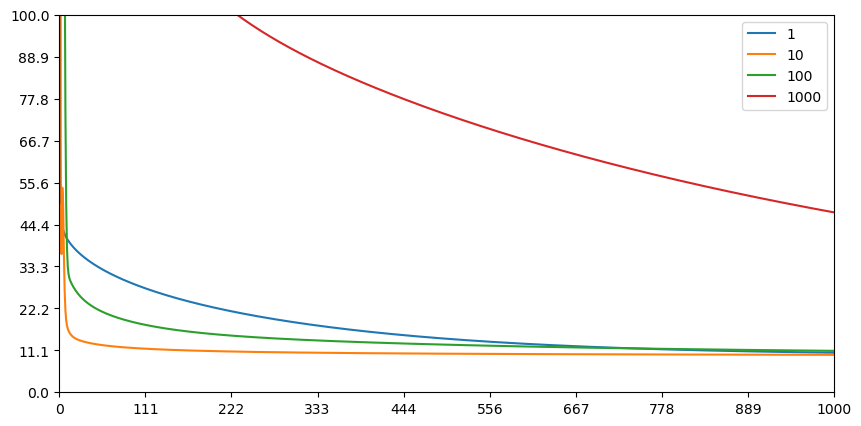

In [9]:
# Training
dim = 18*9+1
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)
learning_rate = [1, 10, 100, 1000]
iter_time = 1000
eps = 0.0000000001

plt.figure(figsize=(10, 5), dpi=100)
plt.subplot(1,1,1)

for l_r in learning_rate:
    loss_iter = []
    w = np.zeros([dim, 1])
    adagrad = np.zeros([dim, 1])
    for t in range(iter_time):
        loss = np.sqrt(np.sum(np.power(np.dot(x,w) - y, 2))/471/12) #RMSE
        loss_iter.append(loss)
        gradient = 2*np.dot(x.transpose(), np.dot(x,w) - y) #dim*1
        adagrad += gradient**2
        w = w - l_r * gradient / np.sqrt(adagrad + eps)
    plt.plot([_ for _ in range(iter_time)], loss_iter, label=str(l_r))
    
plt.xlim(0, 1000)
plt.xticks(np.linspace(0, 1000, 10, endpoint=True))
plt.ylim(0, 100)
plt.yticks(np.linspace(0, 100, 10, endpoint=True))
plt.legend(loc='upper right')
plt.show()

从图中可以看出当learning_rate设置为10时，其loss收敛速度最快，且loss最低；当learning_rate设置为1000时，其loss收敛速度最慢，且loss最大。learning_rate设置为100时，介于learing_rate为1和10之间。

## 第二题

In [7]:
# Extract 9hours data
x = np.empty([12*471, 18*9], dtype = float)
y = np.empty([12*471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month*471 + day*24 + hour, :] = month_data[month][:,day*24 + hour : day*24 + hour + 9].reshape(1, -1)
            y[month*471 + day*24 + hour, 0] = month_data[month][9, day*24 + hour + 9]
            
# Normalize
mean_x = np.mean(x, axis = 0) # 18*9
std_x = np.std(x, axis = 0) # 18*9
for i in range(len(x)): # 12*471
    for j in range(len(x[0])): # 18*9
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j])/std_x[j]
            
# Validation Set
x_train_set = x[: math.floor(len(x)*0.8), :]
y_train_set = y[: math.floor(len(y)*0.8), :]

x_validation = x[math.floor(len(x)*0.8): , :]
y_validation = y[math.floor(len(y)*0.8): , :]

# Training on Validation set
dim = 18*9+1
w = np.zeros([dim, 1])
x_train_set = np.concatenate((np.ones([4521, 1]), x_train_set), axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001

for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set,w) - y_train_set, 2))/4521) #RMSE
    if t%100 == 0 :
        print(str(t) + ":" + str(loss))
    gradient = 2*np.dot(x_train_set.transpose(), np.dot(x_train_set,w) - y_train_set) #dim*1
    adagrad += gradient**2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight_9hurs.npy', w)

# Testing on Validation set
x_validation = np.concatenate((np.ones([1131, 1]), x_validation), axis = 1).astype(float)
w = np.load('weight_9hurs.npy')
ans_y = np.dot(x_validation, w)
rmse = np.sqrt(np.sum(np.power(ans_y - y_validation, 2))/1131)
print("RMSE = %f" % rmse)

0:49.43291106445307
100:12.95963086474921
200:10.811920988889527
300:10.41064967341952
400:10.208028547616623
500:10.079654299323721
600:9.990478322437289
700:9.9249390610112
800:9.874828154641333
900:9.83538342909852
RMSE = 10.720802


In [7]:
# Extract 5hours data
x = np.empty([12*471, 18*5], dtype = float)
y = np.empty([12*471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month*471 + day*24 + hour, :] = month_data[month][:,day*24 + hour + 4 : day*24 + hour + 9].reshape(1, -1)
            y[month*471 + day*24 + hour, 0] = month_data[month][9, day*24 + hour + 9]
            
# Normalize
mean_x = np.mean(x, axis = 0) # 18*5
std_x = np.std(x, axis = 0) # 18*5
for i in range(len(x)): # 12*471
    for j in range(len(x[0])): # 18*5
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j])/std_x[j]
            
# Validation Set
x_train_set = x[: math.floor(len(x)*0.8), :]
y_train_set = y[: math.floor(len(y)*0.8), :]

x_validation = x[math.floor(len(x)*0.8): , :]
y_validation = y[math.floor(len(y)*0.8): , :]

# Training on Validation set
dim = 18*5+1
w = np.zeros([dim, 1])
x_train_set = np.concatenate((np.ones([4521, 1]), x_train_set), axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001

for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set,w) - y_train_set, 2))/4521) #RMSE
    if t%100 == 0 :
        print(str(t) + ":" + str(loss))
    gradient = 2*np.dot(x_train_set.transpose(), np.dot(x_train_set,w) - y_train_set) #dim*1
    adagrad += gradient**2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight_9hurs.npy', w)

# Testing on Validation set
x_validation = np.concatenate((np.ones([1131, 1]), x_validation), axis = 1).astype(float)
w = np.load('weight_9hurs.npy')
ans_y = np.dot(x_validation, w)
rmse = np.sqrt(np.sum(np.power(ans_y - y_validation, 2))/1131)
print("RMSE = %f" % rmse)

0:49.43291106445307
100:10.993117041800973
200:10.402303894229622
300:10.16905296233657
400:10.052660610802597
500:9.98689649460583
600:9.947061819182645
700:9.921918360045778
800:9.905603782058794
900:9.894789700912078
RMSE = 10.594446


由上结果可知，只取第5到9小时去预测第10小时的结果会比取前9小时去预测第10小时的结果精度高一点，出现这种问题的原因：可能是因为数据过多的去fit了train set，从而造成过拟合。

## 第三题

In [6]:
# Extract 9hours data and only PM 2.5 feature
month_data = {}
for month in range(12):
    sample = np.empty([1,480])
    for day in range(20):
        sample[:, day*24 : (day+1)*24] = raw_data[9, :]
    month_data[month] = sample

x = np.empty([12*471, 1*9], dtype = float)
y = np.empty([12*471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month*471 + day*24 + hour, :] = month_data[month][:, day*24 + hour : day*24 + hour + 9].reshape(1, -1)
            y[month*471 + day*24 + hour, 0] = month_data[month][0, day*24 + hour + 9]
            
# Normalize
mean_x = np.mean(x, axis = 0) # 1*9
std_x = np.std(x, axis = 0) # 1*9
for i in range(len(x)): # 12*471
    for j in range(len(x[0])): # 1*9
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j])/std_x[j]
            
# Validation Set
x_train_set = x[: math.floor(len(x)*0.8), :]
y_train_set = y[: math.floor(len(y)*0.8), :]

x_validation = x[math.floor(len(x)*0.8): , :]
y_validation = y[math.floor(len(y)*0.8): , :]

# Training on Validation set
dim = 1*9+1
w = np.zeros([dim, 1])
x_train_set = np.concatenate((np.ones([4521, 1]), x_train_set), axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001

for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set,w) - y_train_set, 2))/4521) #RMSE
    if t%100 == 0 :
        print(str(t) + ":" + str(loss))
    gradient = 2*np.dot(x_train_set.transpose(), np.dot(x_train_set,w) - y_train_set) #dim*1
    adagrad += gradient**2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight_9hurs.npy', w)

# Testing on Validation set
x_validation = np.concatenate((np.ones([1131, 1]), x_validation), axis = 1).astype(float)
w = np.load('weight_9hurs.npy')
ans_y = np.dot(x_validation, w)
rmse = np.sqrt(np.sum(np.power(ans_y - y_validation, 2))/1131)
print("RMSE = %f" % rmse)

0:50.34089057934963
100:7.207795000100473
200:6.855844612074231
300:6.685486381032245
400:6.599023658750972
500:6.555347677862584
600:6.533347522235891
700:6.522273266415139
800:6.516696336047224
900:6.513885108152073
RMSE = 6.515596


只取PM 2.5去预测比取所有18个features的预测精度更高，是因为feature的数量过多，会导致模型在数据集上会overfitting

## 第四题

暂时没时间做了。。。